In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score

In [3]:
def get_num_groups(values):

    # Convert the list to a numpy array
    X = np.array(values).reshape(-1, 1)

    # Silhouette Score
    silhouette_scores = []
    for k in range(2, len(values)):
        kmeans = KMeans(n_clusters=k)
        clusters = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, clusters))

    # Elbow Method
    inertia_values = []
    for k in range(1, len(values) + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        inertia_values.append(kmeans.inertia_)

    plt.plot(range(1, len(values) + 1), inertia_values, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

    # Find the optimal number of clusters based on the silhouette score
    optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Add 2 because silhouette score starts from 2 clusters
    print("Optimal number of clusters (Silhouette Score):", optimal_num_clusters)
    
    return optimal_num_clusters

In [4]:
def get_groups(values, k, df):
    # Convert the list to a numpy array
    X = np.array(values).reshape(-1, 1)

    # Define the number of clusters (2 in this case, for the two groups)
    n_clusters = k

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters,n_init="auto",random_state=42)
    kmeans.fit(X)

    # Get the cluster labels
    cluster_labels = kmeans.labels_

    # Initialize lists for each cluster
    clusters = [[] for _ in range(n_clusters)]

    # Assign each value to its corresponding cluster
    for value, label in zip(values, cluster_labels):
        clusters[label].append(value)

    # Print the clusters
    outs=[]
    for i, cluster in enumerate(clusters):
        #print(f"Cluster {i + 1}: {cluster}")
        out_start=df[df["pos"]==min(cluster)]["start"].tolist()[0]
        out_end=df[df["pos"]==max(cluster)]["end"].tolist()[0]
        outs.append([out_start, out_end])
        
    return sorted(outs, key=lambda x: x[0])


In [48]:
lens=[500,1000,5000,10000]
mtype="snp"
chrom="NW_022145610.1"

In [49]:
def get_figs(size, m, ax):
    
    route="~/WGS/inversion_results/lostruct_results/type_" + mtype + "_size_" + str(size) + "_chromosome_" + chrom
    coords = pd.read_csv(route + "/" + chrom + ".regions.csv")
    mds = pd.read_csv(route + "/mds_coords.csv")
    lpca = coords.join(mds["MDS1"])
    lpca = lpca.join(mds["MDS2"])
    lpca["pos"] = (lpca["end"]+lpca["start"])/2
    lpca["pos"] = lpca["pos"].astype(int)
    
    if abs(lpca[m].max()) > abs(lpca[m].min()):
        thr = 0.1
        outs = lpca[lpca[m]>=thr]
    else:
        thr = -0.1
        outs = lpca[lpca[m]<=thr]

    print(len(outs))
    if len(outs) >= 2:

        ax.plot(lpca["pos"], lpca[m], ".") #plotting window middle points
        ax.plot(outs["pos"], outs[m], ".")
        ax.axhline(thr, color="red")
        
        all_regions=[]
        for k in range(2):
            int_regions=get_groups(outs["pos"].tolist(), k+1, lpca)
            
            if True:
                if k == 0:
                    linestyle="--"
                    ax.axvline(int_regions[0][0], linestyle=linestyle, color="black")
                    ax.axvline(int_regions[0][1], linestyle=linestyle, color="black")
                else:
                    linestyle=":"
                    ax.axvline(int_regions[0][0], linestyle=linestyle, color="black")
                    ax.axvline(int_regions[0][1], linestyle=linestyle, color="black")
                    ax.axvline(int_regions[1][0], linestyle=linestyle, color="black")
                    ax.axvline(int_regions[1][1], linestyle=linestyle, color="black")
                
            all_regions.append(int_regions)
        
        print(all_regions)
        ax.text(1, 1, all_regions,
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=8) #actual genomic coordinates, not middle points!
        
        ax.set_title(m+" Window size: "+str(size),fontsize=8)
    
            
        

19
[[[7601367, 9618600]], [[7601367, 8210526], [9465357, 9618600]]]
18
[[[7653188, 31460853]], [[7653188, 9618600], [30779143, 31460853]]]
2
[[[5973485, 10100913]], [[5973485, 6575700], [9578423, 10100913]]]
7
[[[3930031, 34670389]], [[3930031, 10100913], [21763406, 34670389]]]
11
[[[4128089, 22026988]], [[4128089, 4209724], [21222596, 22026988]]]
11
[[[30779143, 32533262]], [[30779143, 31460853], [32468529, 32533262]]]
5
[[[30241716, 31816910]], [[30241716, 31259753], [31259755, 31816910]]]
3
[[[30241716, 32343152]], [[30241716, 31400800], [31400827, 32343152]]]


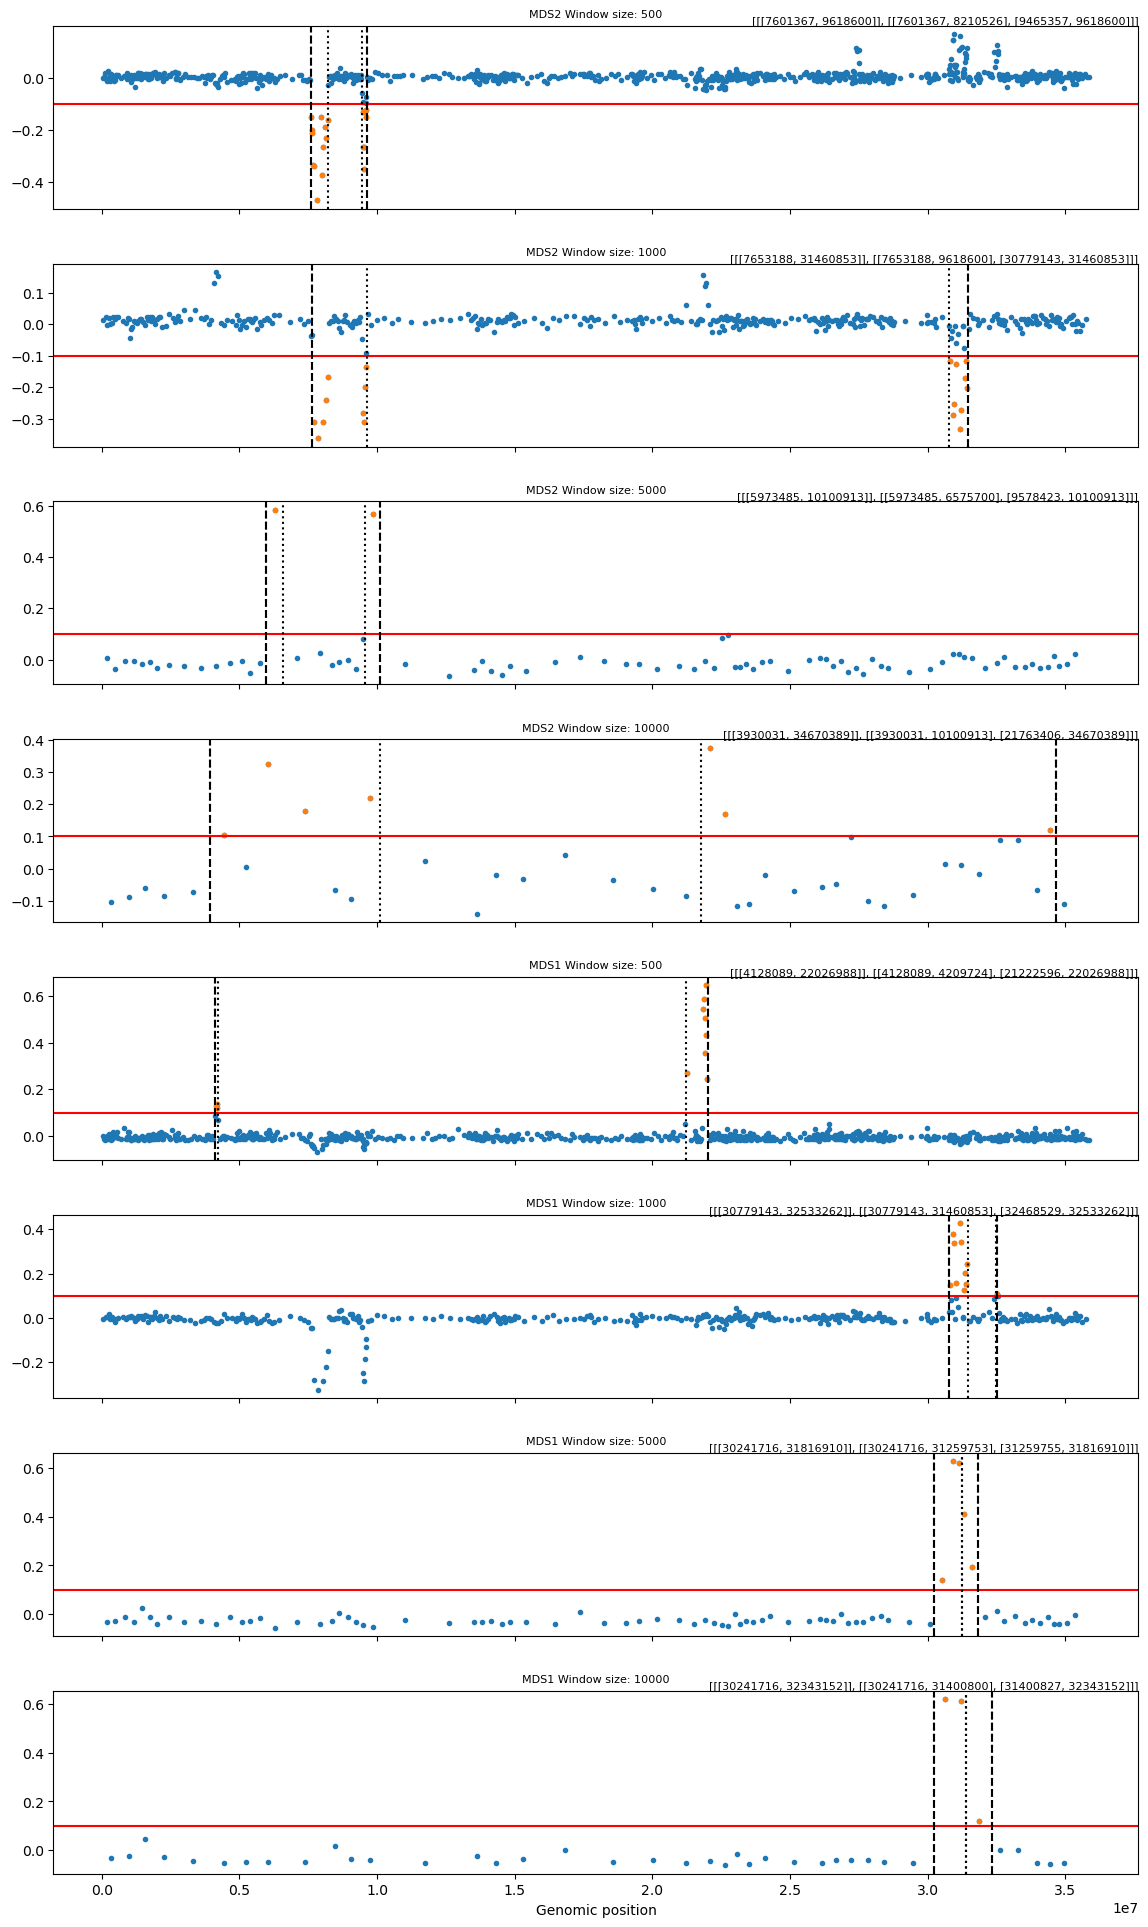

In [50]:
f, axs = plt.subplots(8,1,figsize=(14, 24),sharex=True)

lens=[500,1000,5000,10000]
c=0
for m in ["MDS2","MDS1"]:
    for l in lens:
        get_figs(l,m,axs[c])
        c+=1
plt.subplots_adjust(hspace=0.3)
plt.xlabel("Genomic position")
fname="outlier_regions_"
#plt.savefig(fname+ mtype + "_chromosome_" + chrom+"nb3.pdf")
#get_figs(500,axs,"MDS2")